# Save figures for publication 
Author: Pia Rautenstrauch

Date: 2024-01-15

Abbreviation for Treatment-control use-case: TCU

## Requirements
- [x] Fontsize: > 7 - 12
- [x] Font type: Arial
- [x] Linewidth 0.25pt-1pt (defaults to 1)
- [x] dpi: 600


## Other modifications
- [x] random order of plotting of colors in umap (https://github.com/scverse/scanpy/issues/891)

Anaconda environment: scib_v1.0.1_min


In [1]:
# Imports
import os
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import scib
import scanpy as sc
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import rc

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
scib.__version__

'1.0.1'

In [4]:
# From https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [5]:
sc.set_figure_params(dpi_save=600, dpi=100, transparent=True, format='png', fontsize=18, figsize=(200*px, 140*px))

In [6]:
plt.rcParams['figure.figsize']

[2.7777777777777777, 1.9444444444444444]

In [7]:
# overwrite scanpy/matplotlib default font: chose: Arial

In [8]:
# Need to remove chached fonts

In [9]:
! rm ~/.cache/matplotlib -rf

In [10]:
font_dirs = ["miniconda3/envs/scib_v1.0.1_min/fonts"]  # The path to the custom font file.
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

In [11]:
# change font
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

In [12]:
# clr transform protein data
# Source: https://github.com/theislab/scanpy/issues/1208
# Slightly modified to account for adata properties
def clr_transform(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    seurat_clr = (lambda x: np.log1p(x/ (np.exp(np.sum(np.log1p(x[x > 0]) / x.shape[1])))))

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.todense() if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [13]:
# Publication figures

In [14]:
# List of identifiers of trained models
models = ['BAVAE_sample_100','BAVAE_sample_100_x50','BAVAE_buffer_100', 'BAVAE_buffer_100_x50', 'VAE_100']


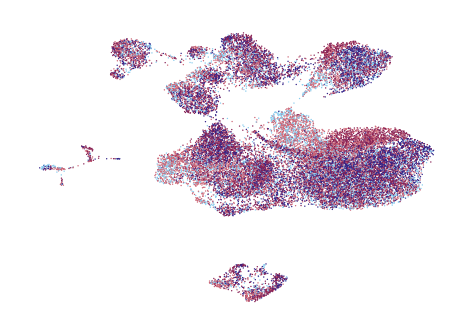

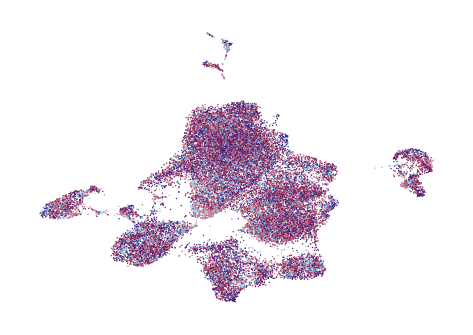

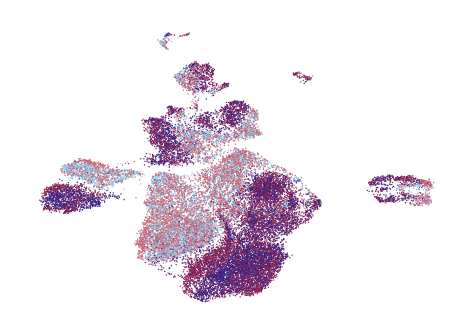

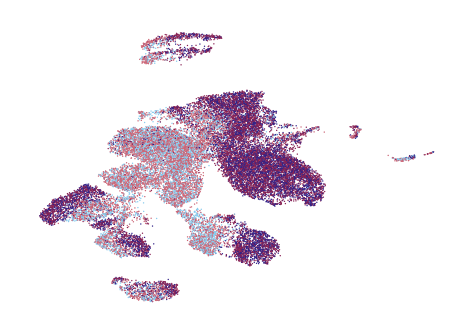

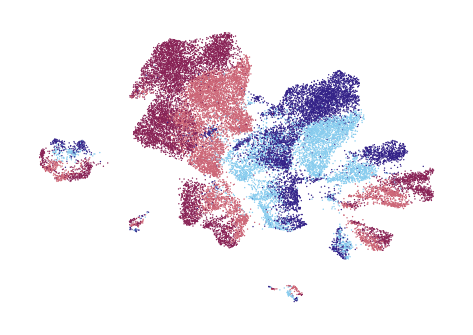

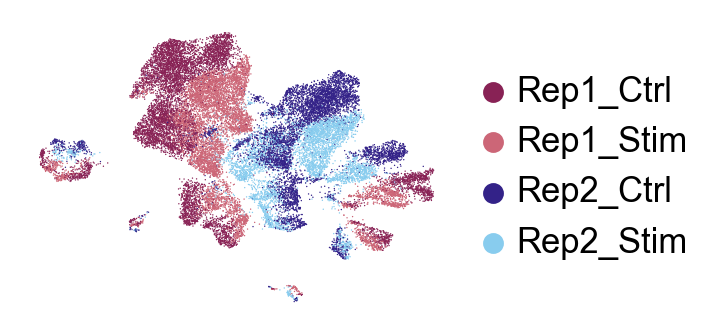

In [15]:
np.random.seed(61)

# Collect computed scores, nested dict is simple to convert to pd.DataFrame
for model in models:
    # Read embeddings
    embedding =  ad.read_h5ad("./../../../models/TCU/{}/adata.h5ad".format(model))
    embedding.obs['replicate'] = embedding.obs['buffer']
    
    # use colorblind friendly colors for variables
    embedding.uns['replicate_colors'] = ['#0173b2', '#de8f05']
    embedding.uns['condition_colors'] = ['#029e73', '#d55e00']
    embedding.uns['sample_colors'] = ['#882255', '#CC6677', '#332288', '#88CCEE']
    
    embedding = sc.pp.subsample(embedding, fraction=1., copy=True)
    
    # rename variables
    embedding.obs['replicate'] = embedding.obs['replicate'].map(lambda x: {'DIG': 'Rep1', 'LLL': 'Rep2'}[x])
    embedding.obs['sample'] = embedding.obs['sample'].map(lambda x: {'DOGMA_DIG_CTRL': 'Rep1_Ctrl', 'DOGMA_DIG_STIM': 'Rep1_Stim', 'DOGMA_LLL_CTRL': 'Rep2_Ctrl', 'DOGMA_LLL_STIM': 'Rep2_Stim'}[x])

    ### Save UMAP visualization as png 
    sc.pl.umap(
        embedding,
        color=['sample'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        save="_{}_TCU_sample.png".format(model),
        legend_loc=None,
        title=[''],
        #legend_fontsize='x-small'
    )

### Save UMAP visualization as png 
sc.pl.umap(
        embedding,
        color=['sample'],
        size=1,
        frameon=False,
        ncols=1,
        save="_{}_TCU_legend_sample.png".format(model),
        legend_fontsize='x-small',
        title=['']
)


In [16]:
# List of identifiers of trained models
models = ['BAVAE_sample_100','BAVAE_buffer_100']


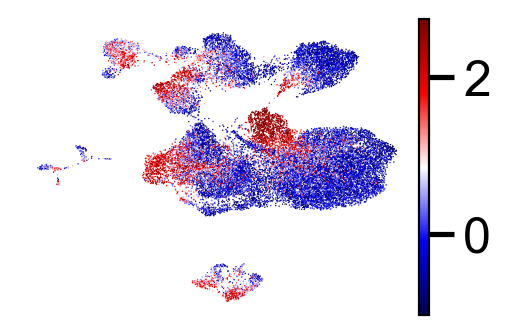

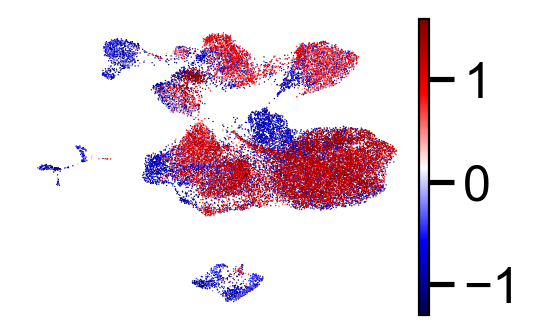

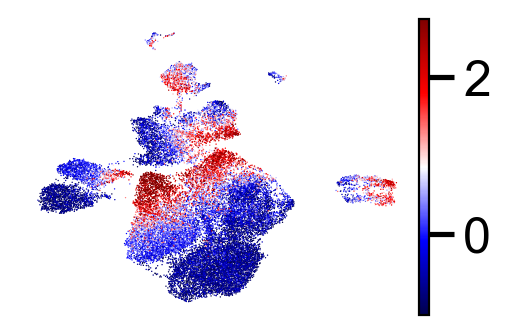

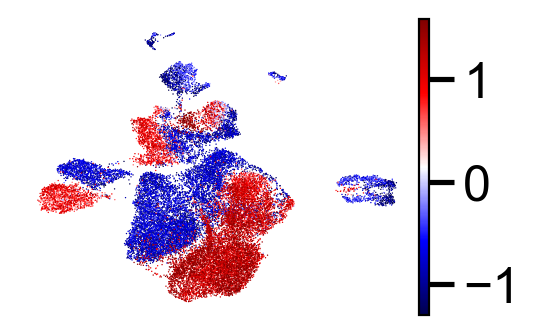

In [17]:
# Annotation activate T-cell: CD69+
np.random.seed(61)

# Collect computed scores, nested dict is simple to convert to pd.DataFrame
for model in models:
    # Read embeddings
    embedding =  ad.read_h5ad("./../../../models/TCU/{}/adata.h5ad".format(model))
    embedding.obs['replicate'] = embedding.obs['buffer']
    
    # add ADT data
    features = pd.read_csv("./../../../data/original/Mimitou2021/DOGMA_seq/DIG_CTRL/ADT/" +  "features.tsv.gz", header=None, names=["protein_names"]).set_index('protein_names')
    protein = sc.AnnData(embedding.obsm['ADT'], obs=embedding.obs[[]], var=features)
    clr_transform(protein)
    protein.X = np.array(protein.X)
    sc.pp.scale(protein)
    parsed_protein_names = protein.var.index.tolist()
    combined_protein = protein.X
    for i, p in enumerate(parsed_protein_names):
        protein.obs["{} observed".format(p)] = combined_protein[:, i]
    embedding.obs = embedding.obs.merge(protein.obs, left_index=True, right_index=True, how='left')
    
    
    # use colorblind friendly colors for variables
    embedding.uns['replicate_colors'] = ['#0173b2', '#de8f05']
    embedding.uns['condition_colors'] = ['#029e73', '#d55e00']
    embedding.uns['sample_colors'] = ['#882255', '#CC6677', '#332288', '#88CCEE']
    
    # Random order of plotting
    embedding = sc.pp.subsample(embedding, fraction=1., copy=True)
    
    # rename variables
    embedding.obs['replicate'] = embedding.obs['replicate'].map(lambda x: {'DIG': 'Rep1', 'LLL': 'Rep2'}[x])
    embedding.obs['sample'] = embedding.obs['sample'].map(lambda x: {'DOGMA_DIG_CTRL': 'Rep1_Ctrl', 'DOGMA_DIG_STIM': 'Rep1_Stim', 'DOGMA_LLL_CTRL': 'Rep2_Ctrl', 'DOGMA_LLL_STIM': 'Rep2_Stim'}[x])

    ### Save UMAP visualization as png 
    sc.pl.umap(
        embedding,
        color=['CD69 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=[''],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )

    ### Save UMAP visualization as png 
    sc.pl.umap(
        embedding,
        color=['CD3-2 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        save="_{}_TCU_CD32.png".format(model),
        legend_loc=None,
        title=[''],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )


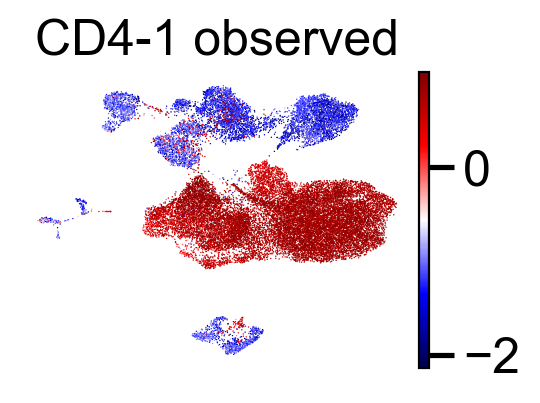

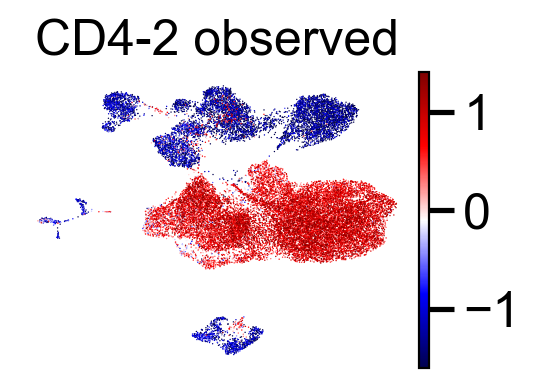

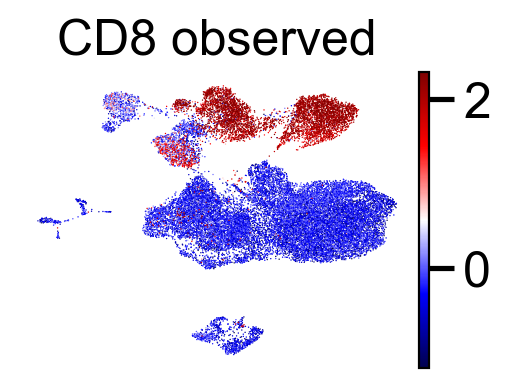

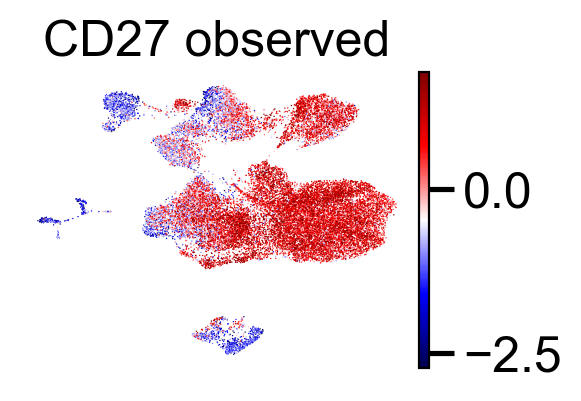

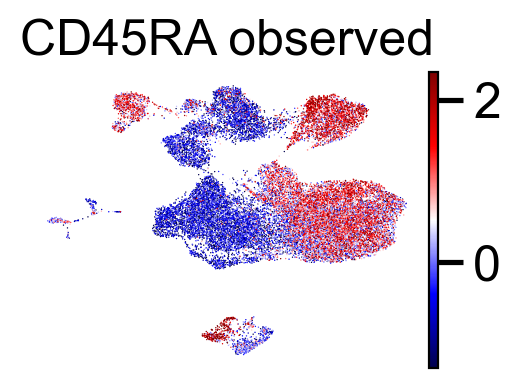

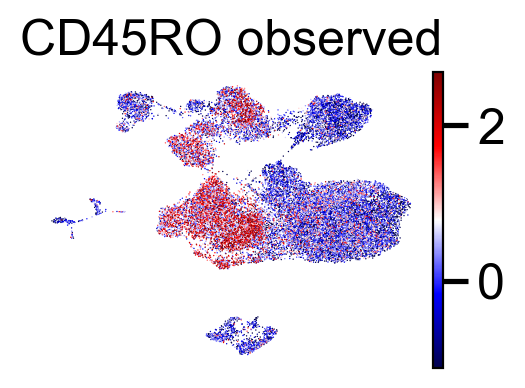

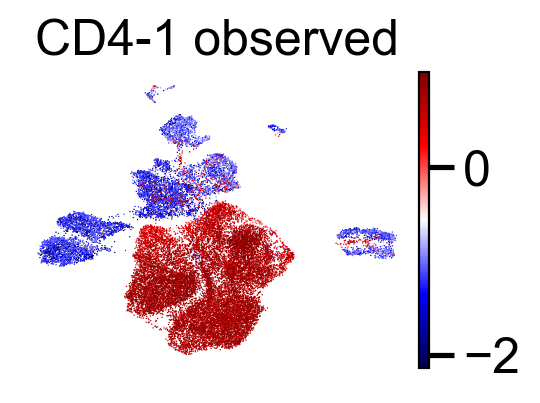

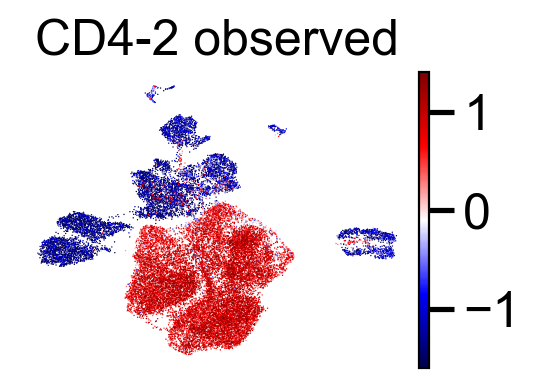

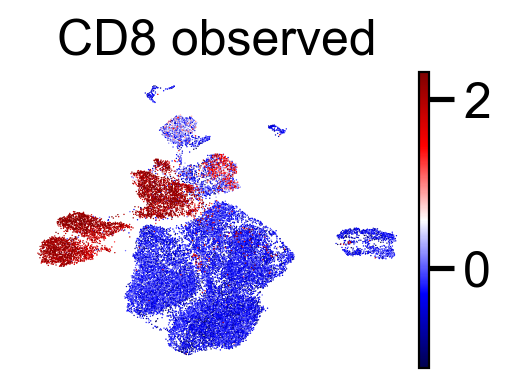

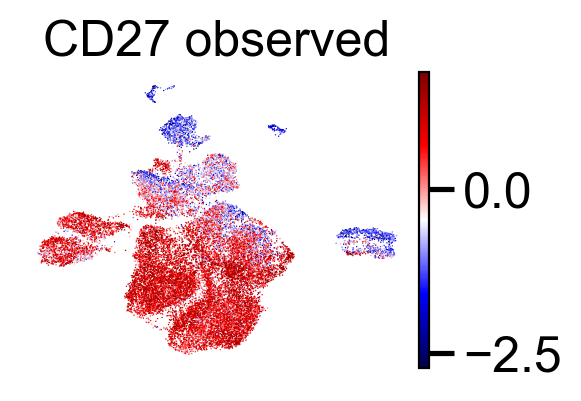

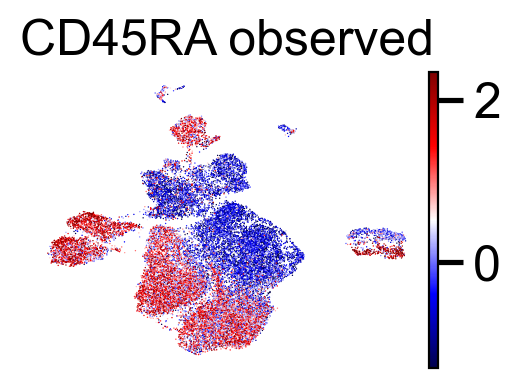

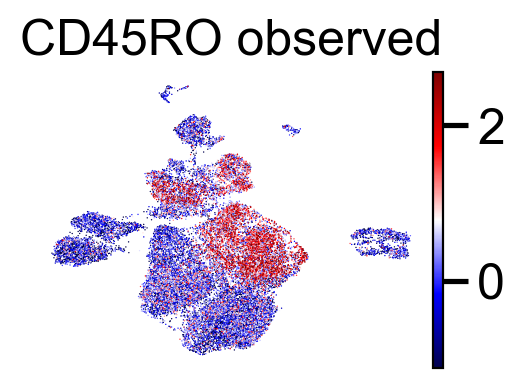

In [18]:
# Annotation Naive CD4+ T cells, Naive CD8+ T cells
# Naive CD4+ T cells: CD4+, CD27+, CD45RA+, CD45RO-
# Naive CD8+ T cells: CD8+, CD27+, CD45RA+, CD45RO-
np.random.seed(61)

# Collect computed scores, nested dict is simple to convert to pd.DataFrame
for model in models:
    # Read embeddings
    embedding =  ad.read_h5ad("./../../../models/TCU/{}/adata.h5ad".format(model))
    embedding.obs['replicate'] = embedding.obs['buffer']
    
    # add ADT data
    features = pd.read_csv("./../../../data/original/Mimitou2021/DOGMA_seq/DIG_CTRL/ADT/" +  "features.tsv.gz", header=None, names=["protein_names"]).set_index('protein_names')
    protein = sc.AnnData(embedding.obsm['ADT'], obs=embedding.obs[[]], var=features)
    clr_transform(protein)
    protein.X = np.array(protein.X)
    sc.pp.scale(protein)
    parsed_protein_names = protein.var.index.tolist()
    combined_protein = protein.X
    for i, p in enumerate(parsed_protein_names):
        protein.obs["{} observed".format(p)] = combined_protein[:, i]
    embedding.obs = embedding.obs.merge(protein.obs, left_index=True, right_index=True, how='left')
    
    
    # use colorblind friendly colors for variables
    embedding.uns['replicate_colors'] = ['#0173b2', '#de8f05']
    embedding.uns['condition_colors'] = ['#029e73', '#d55e00']
    embedding.uns['sample_colors'] = ['#882255', '#CC6677', '#332288', '#88CCEE']
    
    # Random order of plotting
    embedding = sc.pp.subsample(embedding, fraction=1., copy=True)
    
    # rename variables
    embedding.obs['replicate'] = embedding.obs['replicate'].map(lambda x: {'DIG': 'Rep1', 'LLL': 'Rep2'}[x])
    embedding.obs['sample'] = embedding.obs['sample'].map(lambda x: {'DOGMA_DIG_CTRL': 'Rep1_Ctrl', 'DOGMA_DIG_STIM': 'Rep1_Stim', 'DOGMA_LLL_CTRL': 'Rep2_Ctrl', 'DOGMA_LLL_STIM': 'Rep2_Stim'}[x])

    ### Save UMAP visualization as png 
    sc.pl.umap(
        embedding,
        color=['CD4-1 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD4-1 observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )
    
    sc.pl.umap(
        embedding,
        color=['CD4-2 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD4-2 observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )
    
    sc.pl.umap(
        embedding,
        color=['CD8 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD8 observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )
    
    sc.pl.umap(
        embedding,
        color=['CD27 observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD27 observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )
    
    sc.pl.umap(
        embedding,
        color=['CD45RA observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD45RA observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )

    sc.pl.umap(
        embedding,
        color=['CD45RO observed'],
        size=1,
        frameon=False,
        ncols=1,
        wspace=0,
        #save="_{}_TCU_CD69.png".format(model),
        legend_loc=None,
        title=['CD45RO observed'],
        vmin="p1",
        vmax="p99",
        color_map="seismic",
        #legend_fontsize='x-small'
    )




In [1]:
# Kernel restart

In [1]:
# iLISI figures

In [2]:
import anndata as ad
import pandas as pd
import scib
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import matplotlib.font_manager as fm


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use( 'seaborn-colorblind')

In [5]:
# Need to remove chached fonts

In [6]:
! rm ~/.cache/matplotlib -rf

In [7]:
font_dirs = ["/home/prauten/miniconda3/envs/scib_v1.0.1_min/fonts"]  # The path to the custom font file.
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

In [8]:
# change font
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

In [9]:
plt.rcParams['figure.figsize'] = [6.0*4/5, 4.0*4/5]

In [10]:
iLISI = pd.read_csv('./../Evaluation/batch_removal_scores_publication_20240128.csv', index_col=0)

In [11]:
iLISI

,iLISI_sample,iLISI_replicate,iLISI_condition,Model
BAVAE_buffer_100,0.317506,0.812723,0.039879,Liam_replicate_x1
BAVAE_buffer_100_x5,0.326972,0.840453,0.048689,Liam_replicate_x5
BAVAE_buffer_100_x10,0.329217,0.860704,0.052211,Liam_replicate_x10
BAVAE_buffer_100_x25,0.327937,0.869906,0.036150,Liam_replicate_x25
BAVAE_buffer_100_x50,0.327715,0.869068,0.033812,Liam_replicate_x50
BAVAE_buffer_100_x100,0.329877,0.867004,0.047324,Liam_replicate_x100
BAVAE_buffer_100_x1000,0.327570,0.843608,0.050758,Liam_replicate_x1000
BAVAE_sample_100,0.606627,0.816742,0.744925,Liam_sample_x1
BAVAE_sample_100_x5,0.650190,0.849230,0.789217,Liam_sample_x5
BAVAE_sample_100_x10,0.678212,0.861615,0.816832,Liam_sample_x10


In [12]:
iLISI['Model'].value_counts()

Liam_replicate_x1       1
Liam_replicate_x5       1
Liam_replicate_x10      1
Liam_replicate_x25      1
Liam_replicate_x50      1
Liam_replicate_x100     1
Liam_replicate_x1000    1
Liam_sample_x1          1
Liam_sample_x5          1
Liam_sample_x10         1
Liam_sample_x25         1
Liam_sample_x50         1
Liam_sample_x100        1
Liam_sample_x1000       1
Name: Model, dtype: int64

In [13]:
cat_type = CategoricalDtype(categories=['Liam_replicate_x1', 'Liam_replicate_x5', 'Liam_replicate_x10', 'Liam_replicate_x25', 'Liam_replicate_x50', 'Liam_replicate_x100', 'Liam_replicate_x1000','Liam_sample_x1', 'Liam_sample_x5', 'Liam_sample_x10', 'Liam_sample_x25', 'Liam_sample_x50', 'Liam_sample_x100', 'Liam_sample_x1000'], ordered=True)
iLISI['Model'] = iLISI['Model'].astype(cat_type)

In [14]:
iLISI.index = iLISI['Model']
iLISI.index.name = None

In [15]:
iLISI

,iLISI_sample,iLISI_replicate,iLISI_condition,Model
Liam_replicate_x1,0.317506,0.812723,0.039879,Liam_replicate_x1
Liam_replicate_x5,0.326972,0.840453,0.048689,Liam_replicate_x5
Liam_replicate_x10,0.329217,0.860704,0.052211,Liam_replicate_x10
Liam_replicate_x25,0.327937,0.869906,0.036150,Liam_replicate_x25
Liam_replicate_x50,0.327715,0.869068,0.033812,Liam_replicate_x50
Liam_replicate_x100,0.329877,0.867004,0.047324,Liam_replicate_x100
Liam_replicate_x1000,0.327570,0.843608,0.050758,Liam_replicate_x1000
Liam_sample_x1,0.606627,0.816742,0.744925,Liam_sample_x1
Liam_sample_x5,0.650190,0.849230,0.789217,Liam_sample_x5
Liam_sample_x10,0.678212,0.861615,0.816832,Liam_sample_x10


In [16]:
Liam_replicate = pd.DataFrame({

   'sample': [iLISI.loc['Liam_replicate_x1']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x5']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x10']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x25']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x50']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x100']['iLISI_sample'],
                      iLISI.loc['Liam_replicate_x1000']['iLISI_sample']
                     ],
    'replicate': [iLISI.loc['Liam_replicate_x1']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x5']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x10']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x25']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x50']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x100']['iLISI_replicate'],
                      iLISI.loc['Liam_replicate_x1000']['iLISI_replicate']
                     ],
    'condition': [iLISI.loc['Liam_replicate_x1']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x5']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x10']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x25']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x50']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x100']['iLISI_condition'],
                      iLISI.loc['Liam_replicate_x1000']['iLISI_condition']
                     ]
       }, index=['x1', 'x5', 'x10', 'x25', 'x50', 'x100', 'x1000'])
    

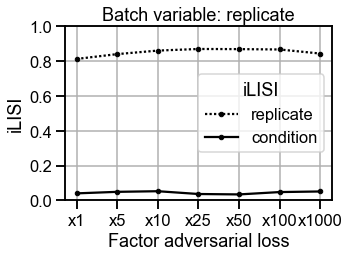

In [17]:
# Liam_replicate['sample'].plot(marker='o', linestyle='--', ylim=(0,1))
Liam_replicate['replicate'].plot(marker='.', linestyle=(0, (1,1)), ylim=(0,1), color='black')
Liam_replicate['condition'].plot(marker='.', linestyle='solid', ylim=(0,1), color='black')
plt.title('Batch variable: replicate')
plt.legend(title='iLISI',loc='center right')
plt.xlabel('Factor adversarial loss')
plt.ylabel('iLISI')
plt.grid()
x = [0, 1, 2, 3, 4, 5, 6]
# labels for x-asix
labels = Liam_replicate.index.values.tolist()
# setting x-axis values
plt.xticks(x, labels)
plt.savefig('./figures/TCU_Liam_replicate_metrics.png', bbox_inches='tight', transparent=True, dpi=600)

In [18]:
Liam_sample = pd.DataFrame({
    'sample': [iLISI.loc['Liam_sample_x1']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x5']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x10']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x25']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x50']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x100']['iLISI_sample'],
                      iLISI.loc['Liam_sample_x1000']['iLISI_sample']
                     ],
    'replicate': [iLISI.loc['Liam_sample_x1']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x5']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x10']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x25']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x50']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x100']['iLISI_replicate'],
                      iLISI.loc['Liam_sample_x1000']['iLISI_replicate']
                     ],
    'condition': [iLISI.loc['Liam_sample_x1']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x5']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x10']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x25']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x50']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x100']['iLISI_condition'],
                      iLISI.loc['Liam_sample_x1000']['iLISI_condition']
                     ]

    

   }, index=['x1', 'x5', 'x10', 'x25', 'x50', 'x100', 'x1000'])

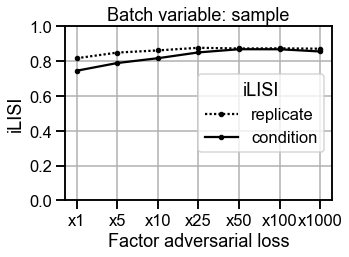

In [19]:
Liam_sample['replicate'].plot(marker='.', linestyle=(0, (1,1)), ylim=(0,1), color='black')
Liam_sample['condition'].plot(marker='.', linestyle='solid', ylim=(0,1), color='black')
plt.title('Batch variable: sample')
plt.legend(title='iLISI',loc='center right')
plt.xlabel('Factor adversarial loss')
plt.ylabel('iLISI')
plt.grid()
x = [0, 1, 2, 3, 4, 5, 6]
# labels for x-asix
labels = Liam_sample.index.values.tolist()
# setting x-axis values
plt.xticks(x, labels)
plt.savefig('./figures/TCU_Liam_sample_metrics.png', bbox_inches='tight', transparent=True, dpi=600)